In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from IPython.display import display, Math

C:\Users\Admin\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
data = np.load(r"C:\Users\Admin\reps\astrostatistics_bicocca_2024\solutions\transient.npy")

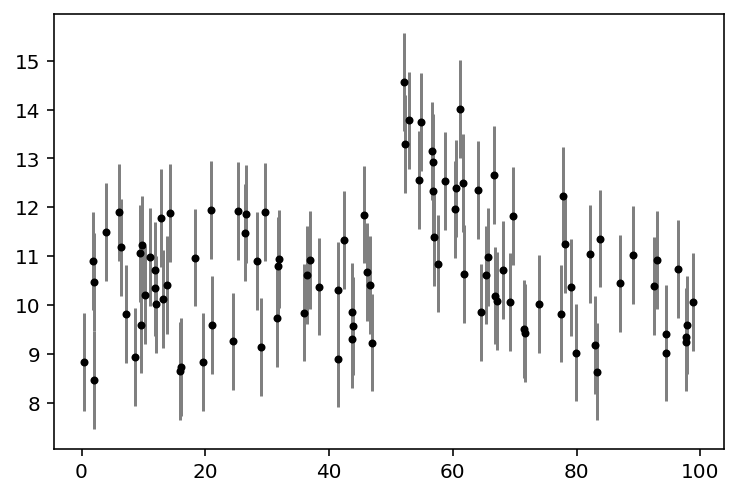

In [3]:
time = data[:,0]
flux = data[:,1]
uncertanties = data[:,2]
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
plt.show()

In [4]:
def burst_model(time, b, A, a, t_0):
    
    return np.where(time<t_0, b, b + A*np.exp(-a*(time-t_0)))

def gaussian_model(time, b, A, a, t_0):
         
    return b+A*np.exp(-(((time-t_0)/a)**2 ) / 2)

def squared_loss(b, A, a, t_0, time, flux, uncertanties, model):
            
    return np.sum(((flux-model(time, b, A, a, t_0)) / uncertanties) ** 2, -1)

In [5]:
def log_likelihood(theta, time, flux, uncertanties, model):
    
    b, A, a, t_0 = theta
    
    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))
 
# Define our uniform prior.
def ptform(u, model):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our prior for each variable."""
    
    b = uniform.ppf(u[0], 0, 50) 
    A = uniform.ppf(u[1], 0, 50)
    t_0 = uniform.ppf(u[3], 0, 100)
    
    if model == burst_model:
        a = np.exp(uniform.ppf(u[2], -5, 5))
    
    elif model == gaussian_model:
        a = uniform.ppf(u[2], 0, 15)
    
    return [b, A, a, t_0]

In [6]:
# Define the dimensionality of our problem.
ndim = 4

# Burst Model

In [7]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], beta[3], time, flux, uncertanties, burst_model)

beta0 = (10, 5, 0.1, 55)
beta_squared = optimize.fmin(f_squared, beta0)
popt = beta_squared

Optimization terminated successfully.
         Current function value: 97.504517
         Iterations: 106
         Function evaluations: 189


In [8]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, uncertanties, burst_model], ptform_args=[burst_model], nlive=300)
sampler.run_nested()
sresults = sampler.results

4530it [01:34, 47.75it/s, +300 | bound: 161 | nc: 1 | ncall: 83143 | eff(%):  5.830 | loglstar:   -inf < -48.760 <    inf | logz: -62.580 +/-  0.207 | dlogz:  0.001 >  0.309]


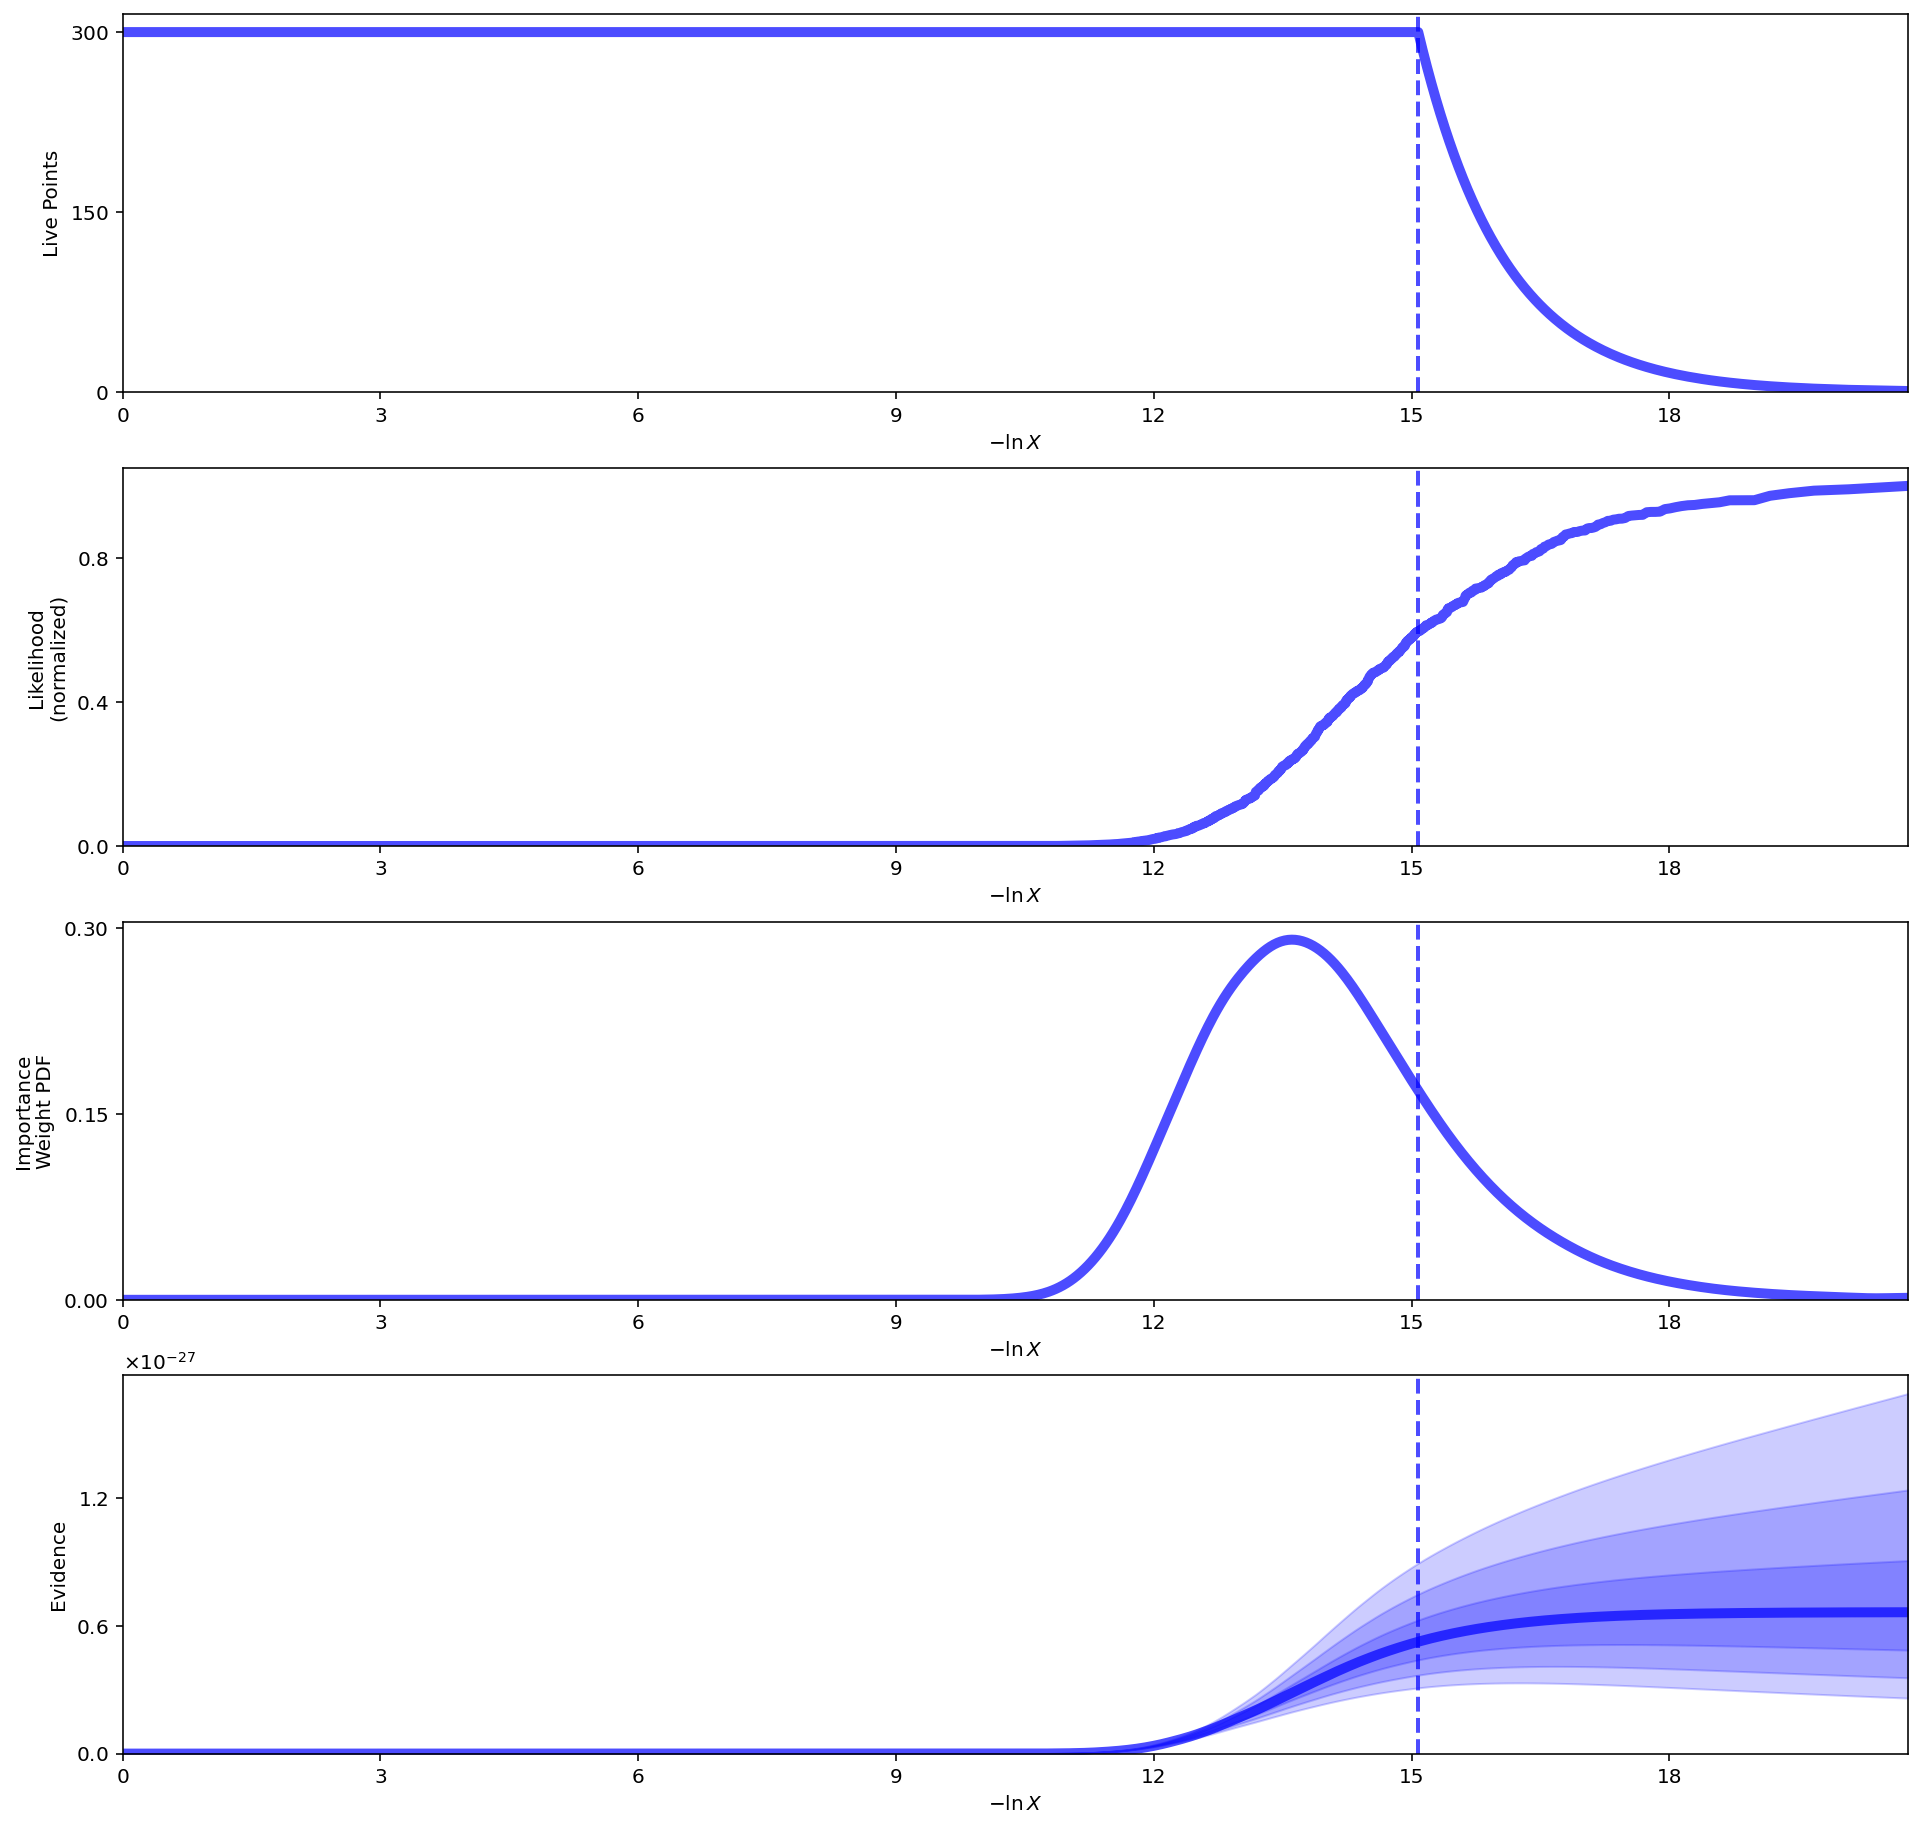

In [9]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

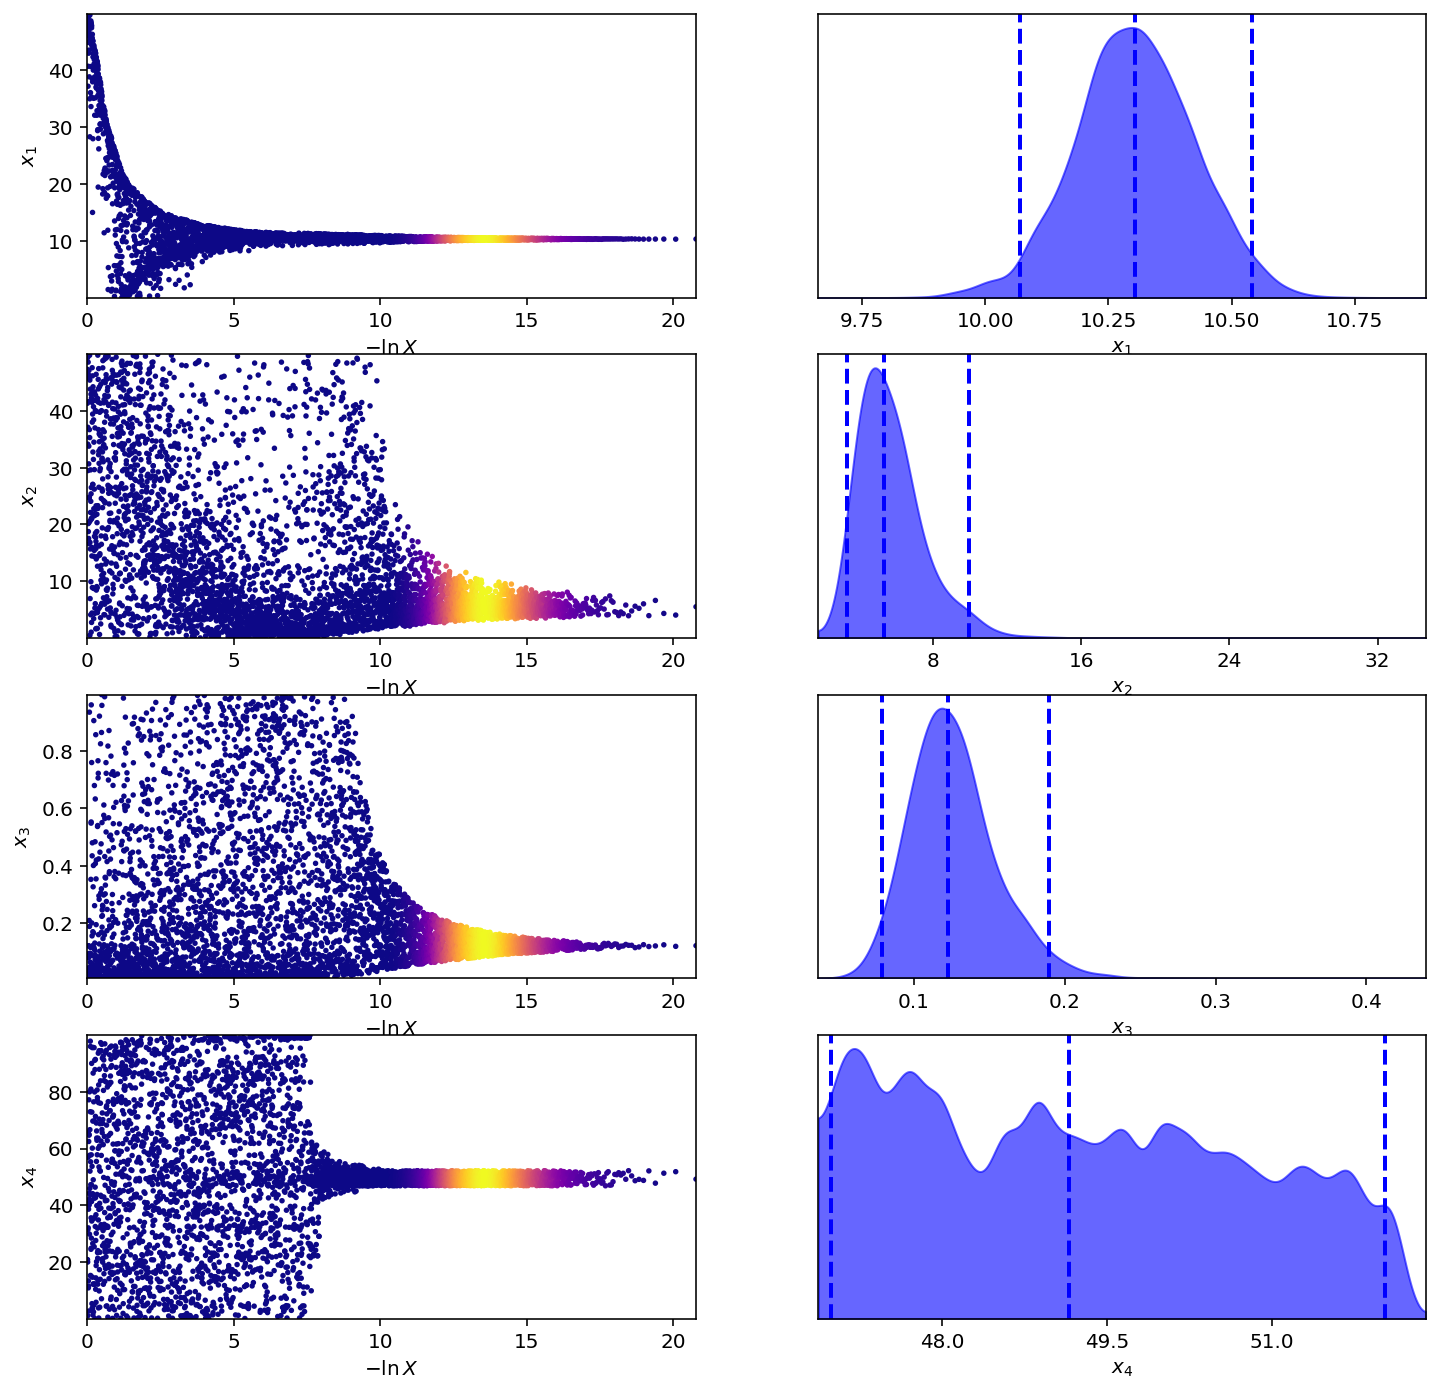

In [10]:
tfig, taxes = dyplot.traceplot(sresults)

In [11]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 6.634966482686791e-28
90% parameter credible regions are:
 [[10.151212339491105, 10.462237795087102], [3.8747044371103945, 7.985295222413917], [0.09294556078414168, 0.1637410575288599], [47.26568993421005, 51.47326337072101]]

Mean and covariance of parameters are: [10.30326144  5.7141777   0.12590727 49.25043355]
[[ 1.44286884e-02  1.41974952e-02  1.25577014e-03 -7.74497372e-03]
 [ 1.41974952e-02  3.00924371e+00  3.01180665e-02 -1.79015344e+00]
 [ 1.25577014e-03  3.01180665e-02  7.93742362e-04 -3.95699280e-03]
 [-7.74497372e-03 -1.79015344e+00 -3.95699280e-03  2.31351552e+00]]


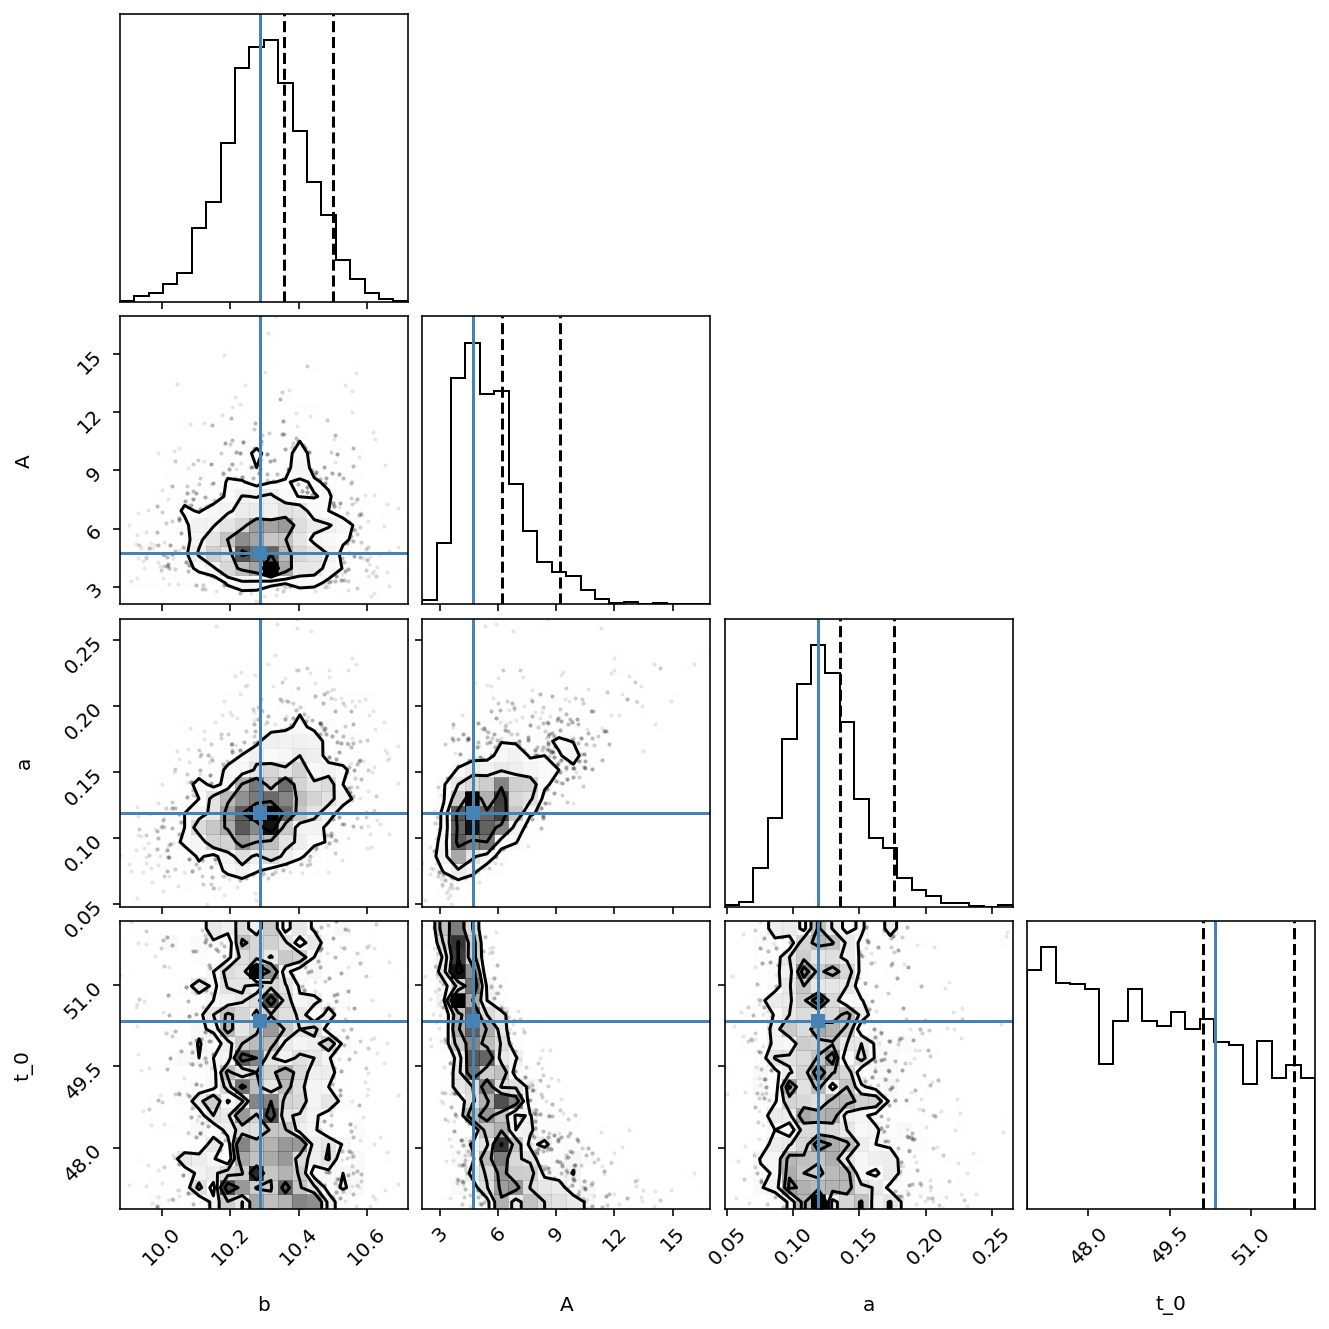

In [12]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ["b", "A", "a", "t_0"]
corner.corner(samples_equal, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [68/100, 95/100]);

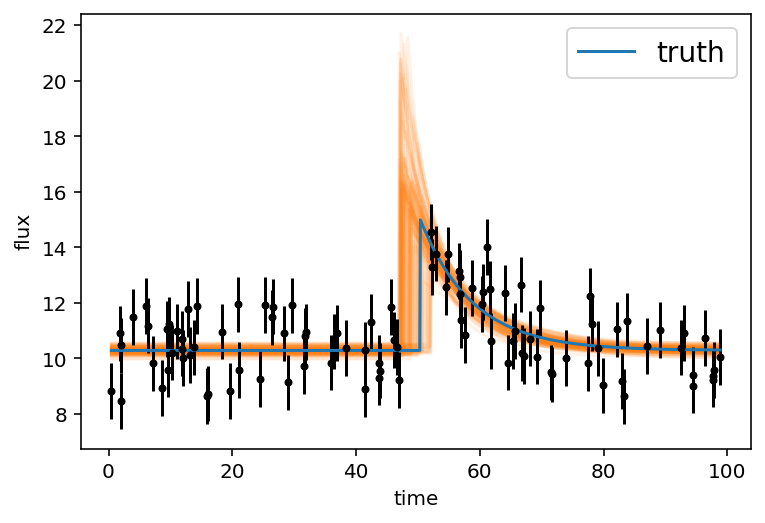

In [13]:
inds = np.random.randint(len(samples_equal), size=100)
x_fit = np.linspace(min(time), max(time), 1000)

for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_fit, burst_model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, burst_model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="truth")
plt.legend(fontsize=14)

plt.xlabel("time")
plt.ylabel("flux");

In [14]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Gaussian Model

In [15]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], beta[3], time, flux, uncertanties, gaussian_model)

beta0 = (10, 5, 10, 55)
beta_squared = optimize.fmin(f_squared, beta0)
popt = beta_squared

Optimization terminated successfully.
         Current function value: 104.801279
         Iterations: 178
         Function evaluations: 306


In [16]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[time, flux, uncertanties, gaussian_model], ptform_args=[gaussian_model], nlive=300)
sampler.run_nested()
sresults_g = sampler.results

4935it [00:58, 84.42it/s, +300 | bound: 90 | nc: 1 | ncall: 51347 | eff(%): 10.255 | loglstar:   -inf < -52.414 <    inf | logz: -67.621 +/-  0.217 | dlogz:  0.001 >  0.309]


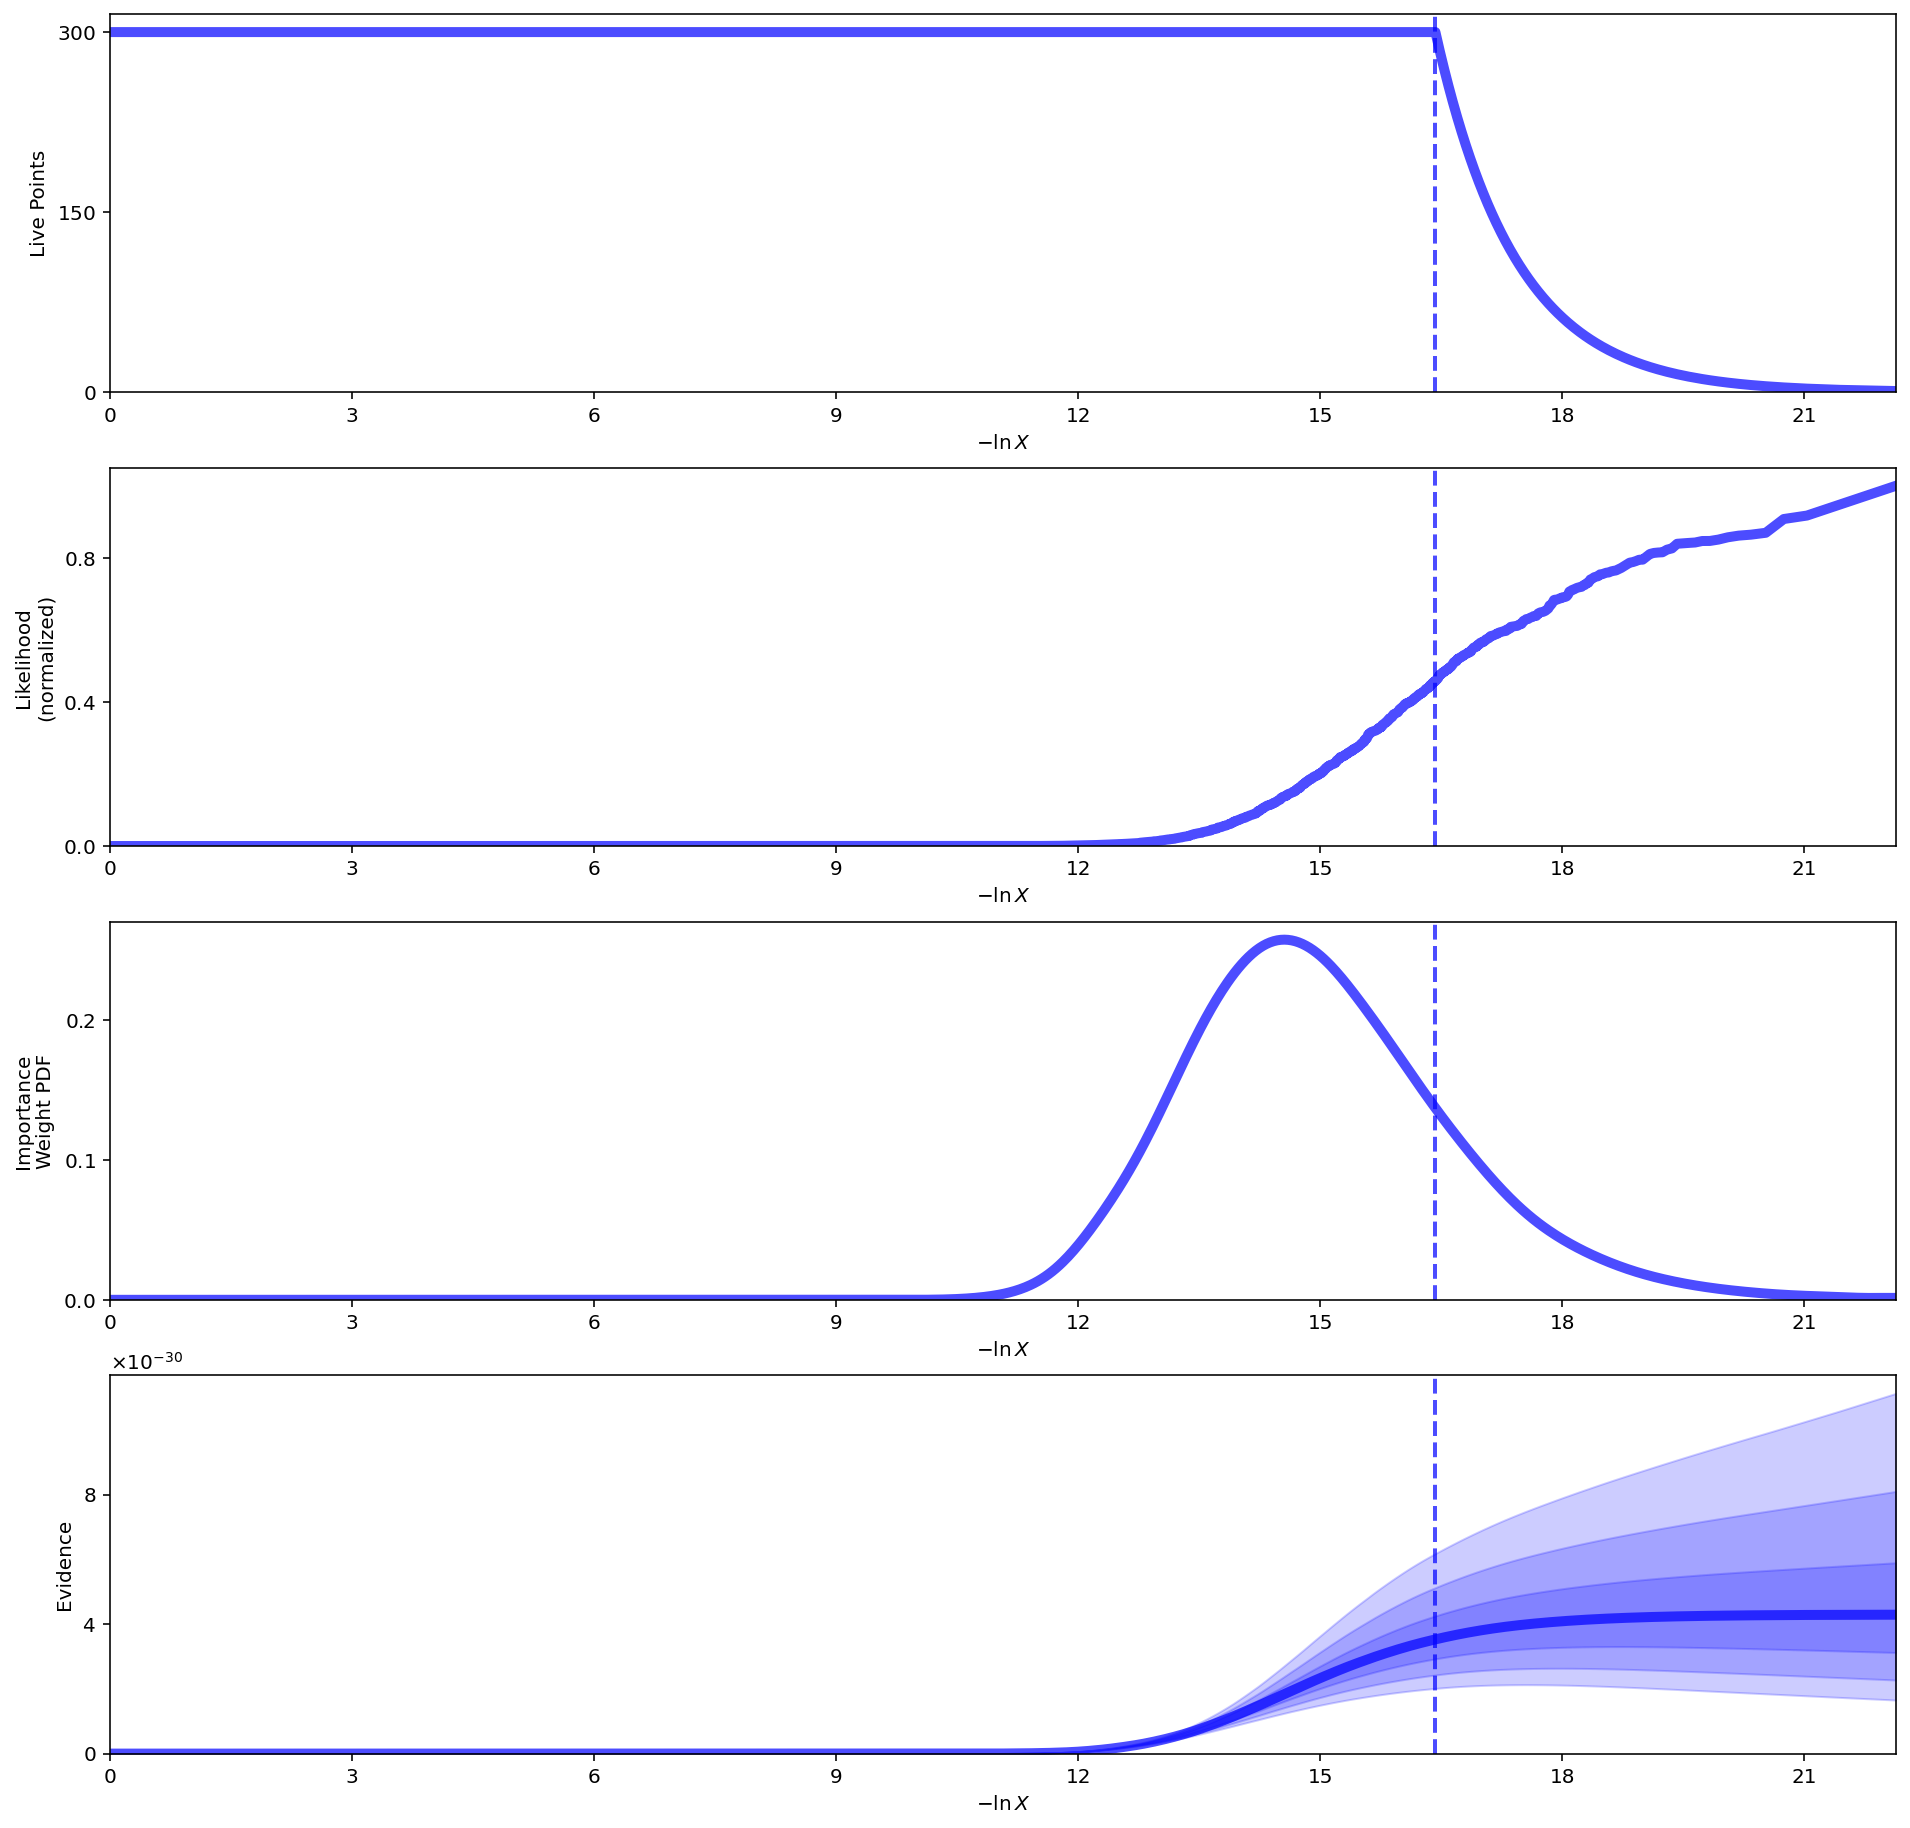

In [17]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_g)

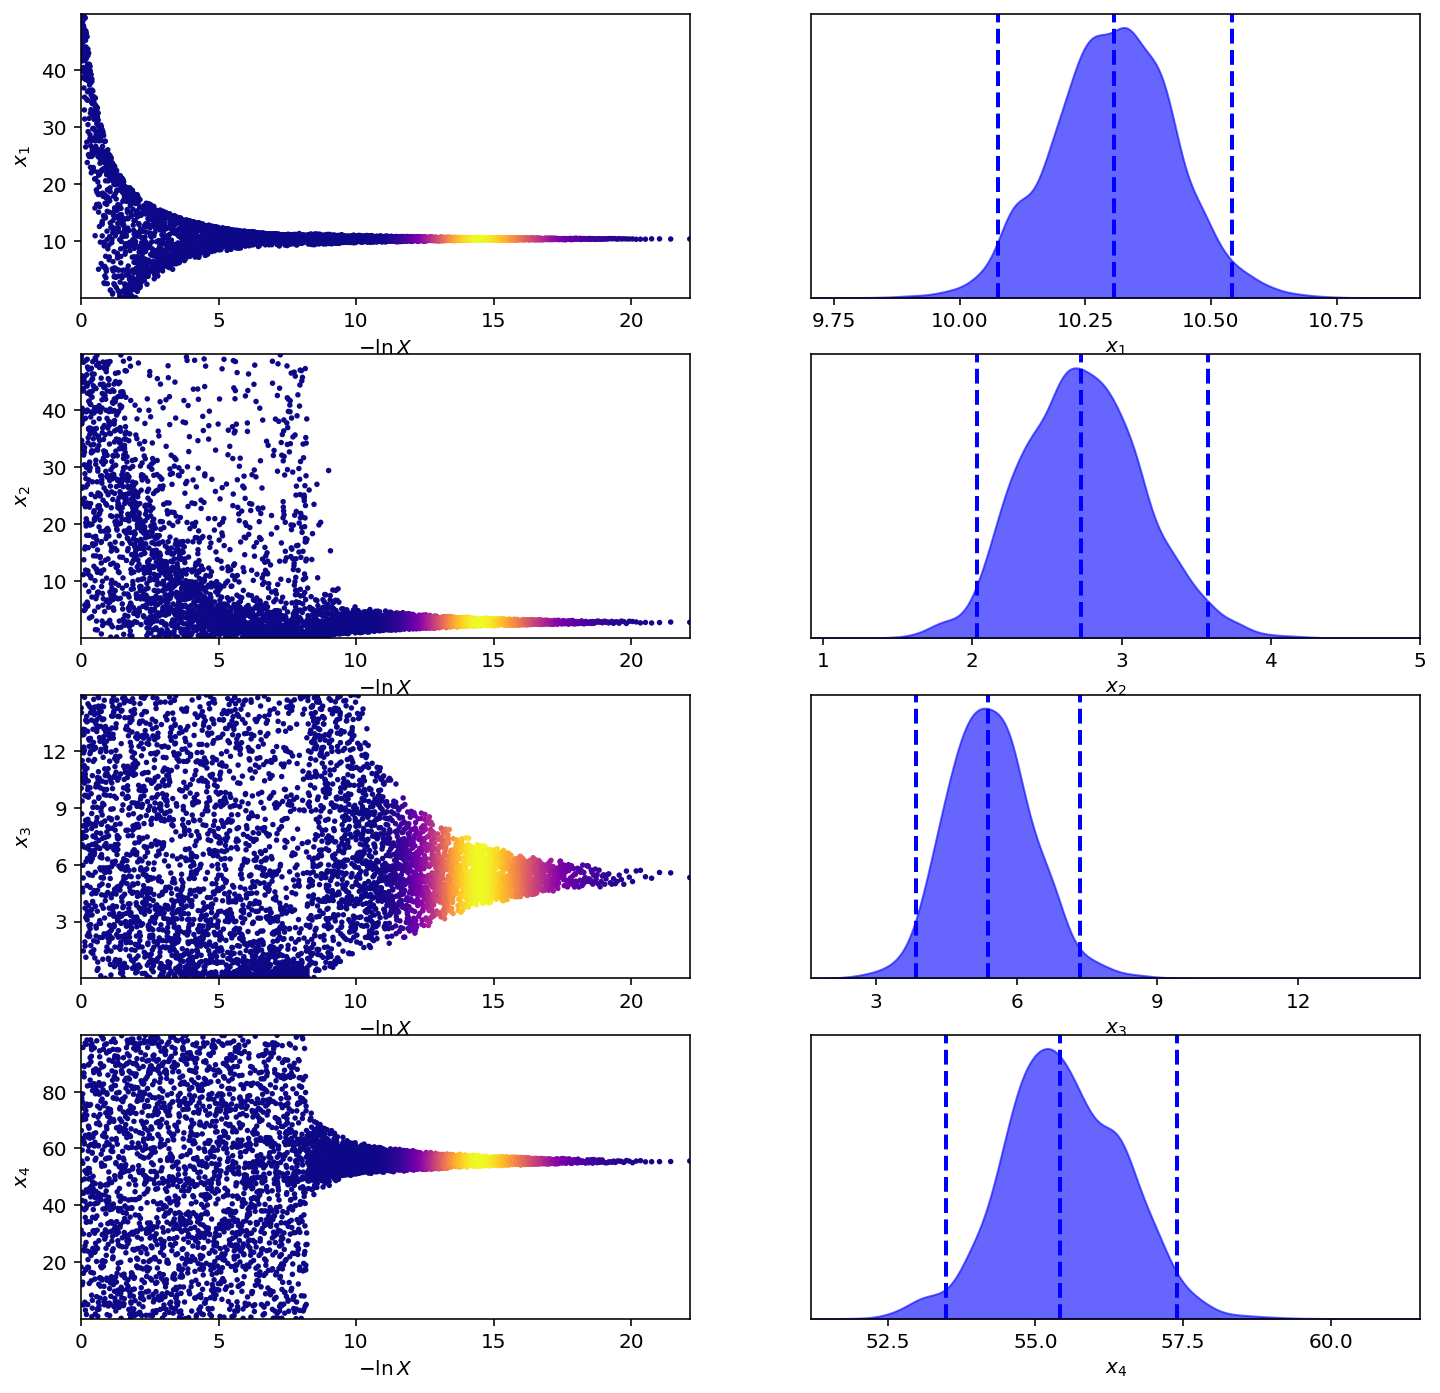

In [18]:
tfig, taxes = dyplot.traceplot(sresults_g)

In [19]:
# Extract sampling results.
samples = sresults_g.samples  # samples
weights = np.exp(sresults_g.logwt - sresults_g.logz[-1])  # normalized weights


evidence = sresults_g.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 4.2899198201337794e-30
90% parameter credible regions are:
 [[10.14341053800399, 10.452814113251765], [2.242971046480432, 3.2659909862307304], [4.340636351651371, 6.625380147110056], [54.28275792761209, 56.78909365742074]]

Mean and covariance of parameters are: [10.30457093  2.74306458  5.43618068 55.48472805]
[[ 0.01448198 -0.00949334 -0.03748121 -0.01580278]
 [-0.00949334  0.16105426 -0.16937368 -0.14949903]
 [-0.03748121 -0.16937368  0.82093732  0.31254033]
 [-0.01580278 -0.14949903  0.31254033  1.0117953 ]]


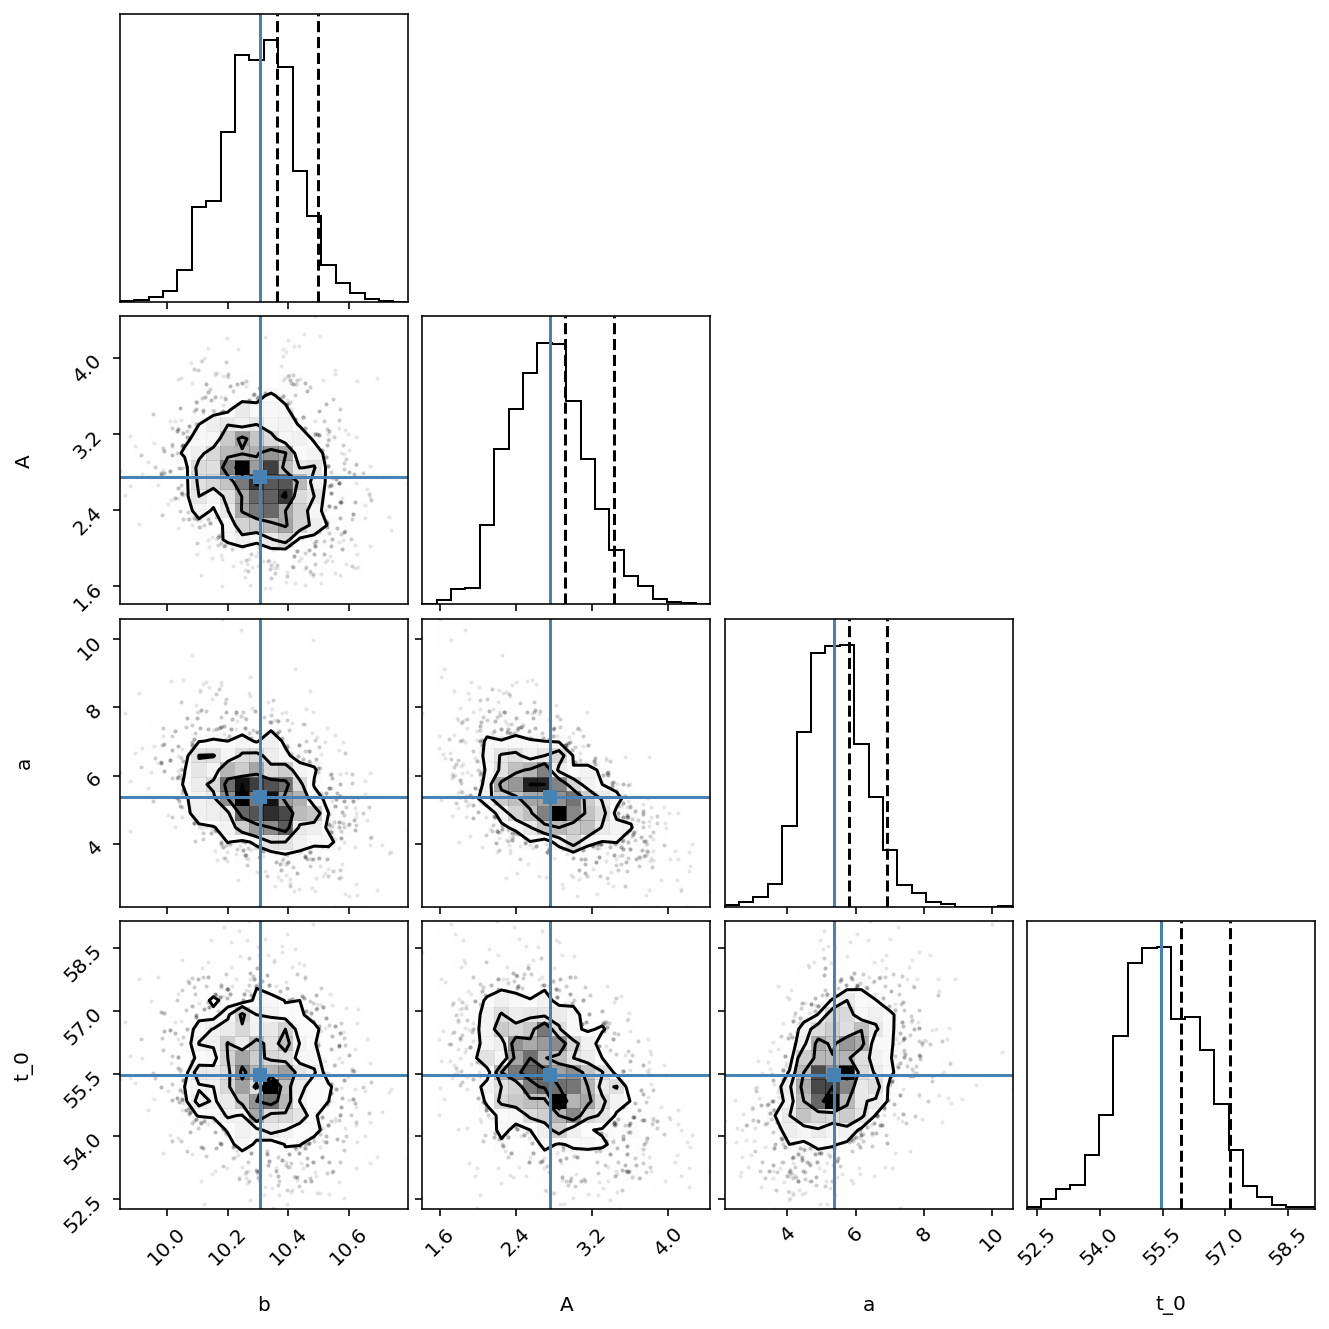

In [20]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ["b", "A", "a", "t_0"]
corner.corner(samples_equal, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [68/100, 95/100]);

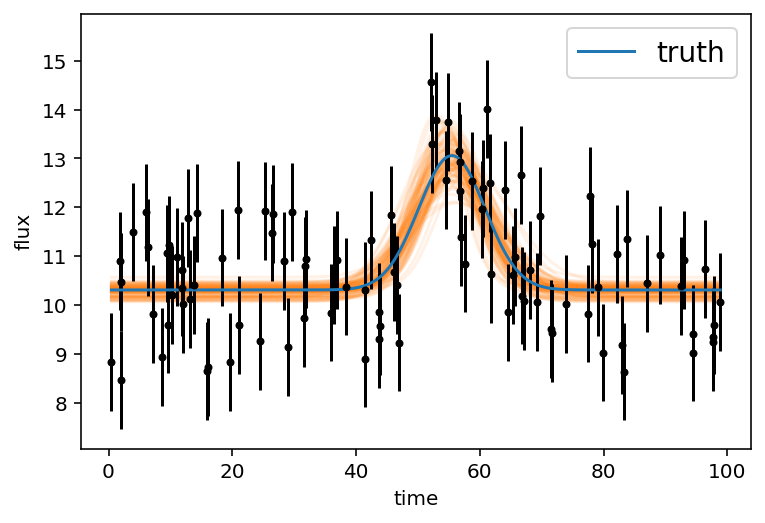

In [21]:
inds = np.random.randint(len(samples_equal), size=100)
x_fit = np.linspace(min(time), max(time), 1000)

for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_fit, gaussian_model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, gaussian_model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="truth")
plt.legend(fontsize=14)

plt.xlabel("time")
plt.ylabel("flux");

In [22]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
np.exp(sresults.logz[-1])/np.exp(sresults_g.logz[-1]) #Decisive evidence

154.66411403651554